In [ ]:
!pip install opendatasets
!pip install tld


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import opendatasets as od
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tld import get_tld, is_tld
import matplotlib.pyplot as plt
import joblib

od.download("https://www.kaggle.com/datasets/siddharthkumar25/malicious-and-benign-urls")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aswinr24
Your Kaggle Key: ··········


100%|██████████| 8.82M/8.82M [00:00<00:00, 62.6MB/s]

In [ ]:
data = pd.read_csv('malicious-and-benign-urls/urldata.csv',header=0)
data = pd.DataFrame(data)
data

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0
...,...,...,...,...
450171,450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1
450172,450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1
450173,450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1
450174,450174,http://atualizapj.com/,malicious,1


Removing unnamed: 0 column

In [ ]:
data=data.drop(['Unnamed: 0'],axis=1)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [ ]:
data.isnull().sum()

url       0
label     0
result    0
dtype: int64

In [ ]:
count = data.label.value_counts()
count

benign       345738
malicious    104438
Name: label, dtype: int64

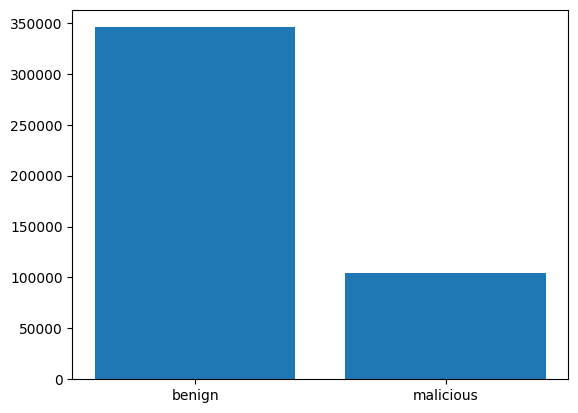

In [ ]:
plt.bar(count.index,count)
plt.show()

Omit 'www' from URLs

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data.head()

,url,label,result
0,https://google.com,benign,0
1,https://youtube.com,benign,0
2,https://facebook.com,benign,0
3,https://baidu.com,benign,0
4,https://wikipedia.org,benign,0


**Extracting the features**

Length of url, tld, tld_length, https, http, hostname len

Characters: @, ?, ., /, //, *, +, #, = etc..

Ip address, short url

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
data['domain'] = data['url'].apply(lambda i: process_tld(i))
data['https'] = data['url'].apply(lambda i : i.count('https'))
data['http'] = (data['url'].replace('https', '', regex=True)).apply(lambda i : i.count('http'))
data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return 0
data['tld_len'] = data['tld'].apply(lambda i: tld_length(i))
data['hostname_len'] = data['url'].apply(lambda i: len(urlparse(i).netloc))
data.head()

,url,label,result,url_len,domain,https,http,tld,tld_len,hostname_len
0,https://google.com,benign,0,18,google.com,1,0,com,3,10
1,https://youtube.com,benign,0,19,youtube.com,1,0,com,3,11
2,https://facebook.com,benign,0,20,facebook.com,1,0,com,3,12
3,https://baidu.com,benign,0,17,baidu.com,1,0,com,3,9
4,https://wikipedia.org,benign,0,21,wikipedia.org,1,0,org,3,13


In [ ]:
data.tail()

,url,label,result,url_len,domain,https,http,tld,tld_len,hostname_len
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,43,ecct-it.com,0,1,com,3,11
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,159,faboleena.com,0,1,com,3,13
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,147,faboleena.com,0,1,com,3,13
450174,http://atualizapj.com/,malicious,1,22,atualizapj.com,0,1,com,3,14
450175,http://writeassociate.com/test/Portal/inicio/I...,malicious,1,139,writeassociate.com,0,1,com,3,18


In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))
data.head()

,url,label,result,url_len,domain,https,http,tld,tld_len,hostname_len,...,=,.,#,%,+,$,!,*,",",//
0,https://google.com,benign,0,18,google.com,1,0,com,3,10,...,0,1,0,0,0,0,0,0,0,1
1,https://youtube.com,benign,0,19,youtube.com,1,0,com,3,11,...,0,1,0,0,0,0,0,0,0,1
2,https://facebook.com,benign,0,20,facebook.com,1,0,com,3,12,...,0,1,0,0,0,0,0,0,0,1
3,https://baidu.com,benign,0,17,baidu.com,1,0,com,3,9,...,0,1,0,0,0,0,0,0,0,1
4,https://wikipedia.org,benign,0,21,wikipedia.org,1,0,org,3,13,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
data['digits']= data['url'].apply(lambda i: digit_count(i))

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
data['letters']= data['url'].apply(lambda i: letter_count(i))

data

,url,label,result,url_len,domain,https,http,tld,tld_len,hostname_len,...,#,%,+,$,!,*,",",//,digits,letters
0,https://google.com,benign,0,18,google.com,1,0,com,3,10,...,0,0,0,0,0,0,0,1,0,14
1,https://youtube.com,benign,0,19,youtube.com,1,0,com,3,11,...,0,0,0,0,0,0,0,1,0,15
2,https://facebook.com,benign,0,20,facebook.com,1,0,com,3,12,...,0,0,0,0,0,0,0,1,0,16
3,https://baidu.com,benign,0,17,baidu.com,1,0,com,3,9,...,0,0,0,0,0,0,0,1,0,13
4,https://wikipedia.org,benign,0,21,wikipedia.org,1,0,org,3,13,...,0,0,0,0,0,0,0,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,43,ecct-it.com,0,1,com,3,11,...,0,0,0,0,0,0,0,1,0,34
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,159,faboleena.com,0,1,com,3,13,...,0,0,0,0,0,0,0,1,21,118
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,147,faboleena.com,0,1,com,3,13,...,0,0,0,0,0,0,0,1,20,109
450174,http://atualizapj.com/,malicious,1,22,atualizapj.com,0,1,com,3,14,...,0,0,0,0,0,0,0,1,0,17


In [ ]:
def short_url(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
data['short_url'] = data['url'].apply(lambda x: short_url(x))

def ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data['ip_address'] = data['url'].apply(lambda i: ip_address(i))
data['ip_address'].value_counts()

0    445936
1      4240
Name: ip_address, dtype: int64

**Data Visualization**

<ipython-input-37-d14f9601ff3f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5)


<Axes: >

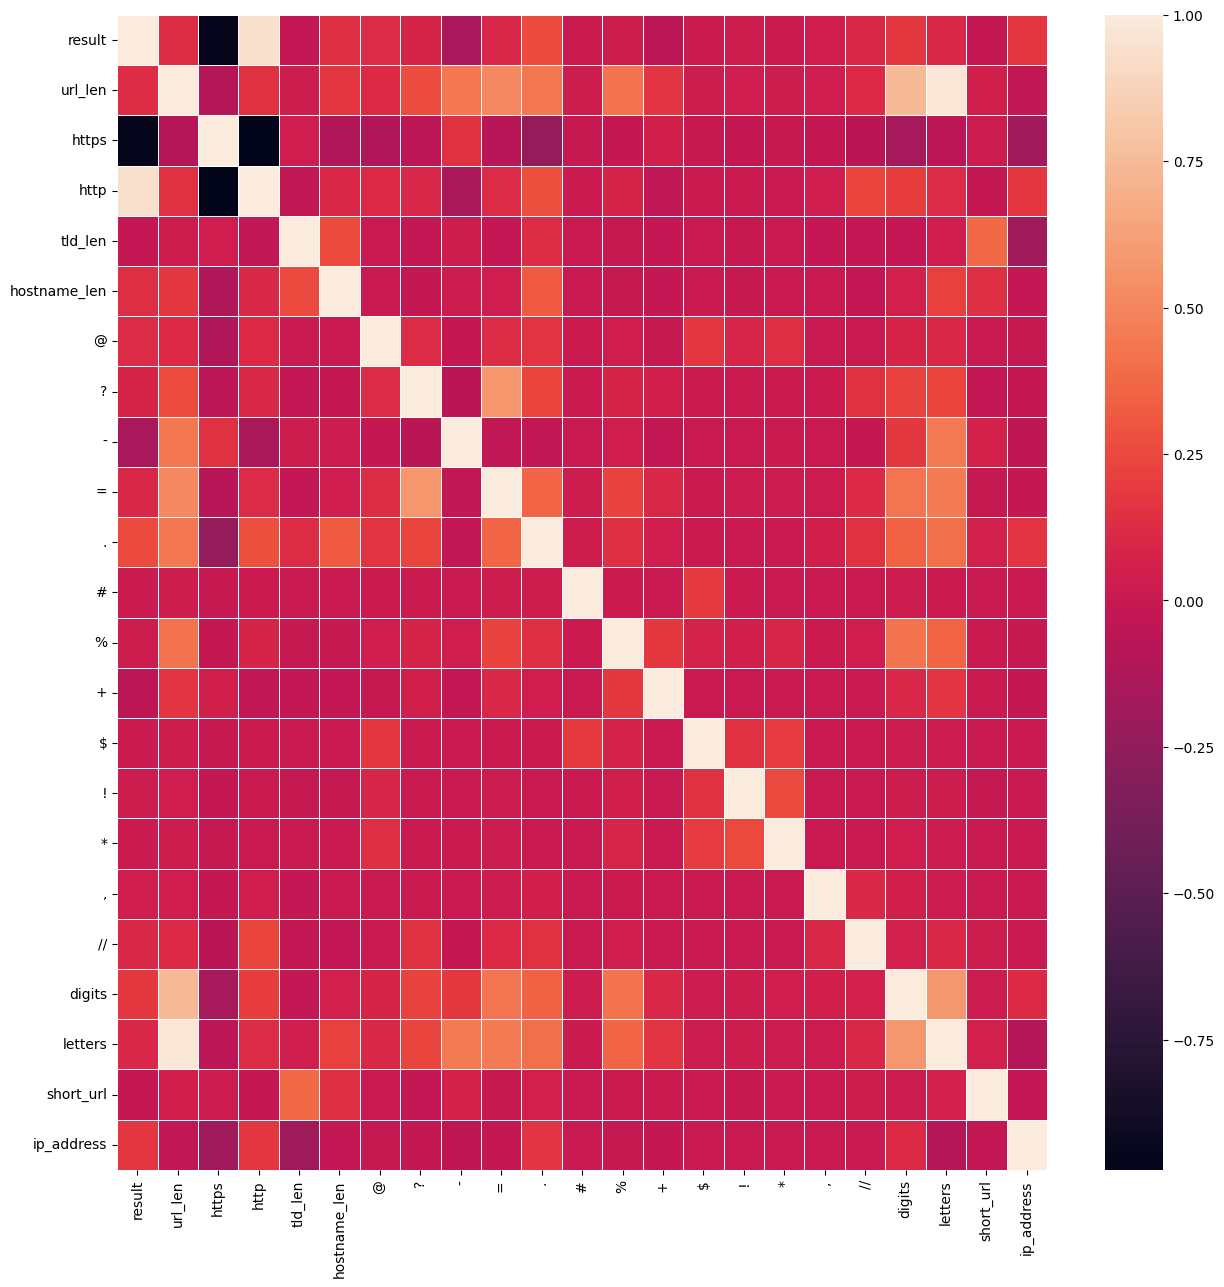

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
print("Percentage Of Phishing/Malware URLs: {:.2f}%".format(len(data[data['result']==1])/len(data['label'])*100))
print("Percentage Of Benign URLs: {:.2f}%".format(len(data[data['result']==0])/len(data['label'])*100))


Percentage Of Phishing/Malware URLs: 23.20%
Percentage Of Benign URLs: 76.80%


In [ ]:
X = data.drop(['label','result','url','domain','tld'],axis=1)
y = data['result']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.head()

,url_len,https,http,tld_len,hostname_len,@,?,-,=,.,...,+,$,!,*,",",//,digits,letters,short_url,ip_address
367504,51,0,1,3,24,0,0,0,0,2,...,0,0,0,0,0,1,0,44,0,0
286248,39,1,0,3,12,0,0,1,0,1,...,0,0,0,0,0,1,0,32,0,0
180683,78,1,0,3,16,0,0,5,0,2,...,0,0,0,0,0,1,3,62,0,0
156395,89,1,0,3,18,0,0,9,0,1,...,0,0,0,0,0,1,8,64,0,0
159544,43,1,0,3,8,0,0,0,0,2,...,0,0,0,0,0,1,0,35,0,0


**Training the Model**

In [ ]:
models = [DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print(f'\nModel Name:')
    print(str(m),'\n')
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('\nTest Accuracy \n')
    print(acc,'\n')
    print('\nConfusion_matrix \n')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()

In [ ]:
classifier=RandomForestClassifier()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
acc = accuracy_score(pred, y_test)
print('Accuracy : ',(acc*100))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))

Accuracy :  99.10813452396819
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     68921
           1       1.00      0.97      0.98     21115

    accuracy                           0.99     90036
   macro avg       0.99      0.98      0.99     90036
weighted avg       0.99      0.99      0.99     90036

[[68830    91]
 [  712 20403]]


In [ ]:
import joblib
joblib.dump(classifier, 'RF_malaciousURL_classifier.pkl',compress=9)

['RF_malaciousURL_classifier.pkl']

**TESTING the model**

In [ ]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 1.0 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn==1.4.1.post1

In [ ]:
import pandas as pd
import joblib
from tld import get_tld
from urllib.parse import urlparse
import re
import requests

def process_input(text):
    df={'url':[text]}
    data=pd.DataFrame(df,columns=['url','url_len','https','http','tld','tld_len','hostname_len','@','?','-','=','.','#','%','+','$','!','*',',','//','digits','letters','short_url','ip_address'])
    data['url'] = data['url'].replace('www.', '', regex=True)
    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['https'] = data['url'].apply(lambda i : i.count('https'))
    data['url'] = data['url'].replace('https', '', regex=True)
    data['http'] = data['url'].apply(lambda i : i.count('http'))
    data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))
    def tld_length(tld):
        try:
            return len(tld)
        except:
            return 0
    data['tld_len'] = data['tld'].apply(lambda i: tld_length(i))
    data['hostname_len'] = data['url'].apply(lambda i: len(urlparse(i).netloc))
    feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
    data = data.drop(["tld"],axis=1)
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))
    def digit_count(url):
        digits = 0
        for i in url:
            if i.isnumeric():
                digits = digits + 1
        return digits
    data['digits']= data['url'].apply(lambda i: digit_count(i))

    def letter_count(url):
        letters = 0
        for i in url:
            if i.isalpha():
                letters = letters + 1
        return letters
    data['letters']= data['url'].apply(lambda i: letter_count(i))

    def short_url(url):
        match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                        'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                        'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                        'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                        'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                        'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                        'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                        'tr\.im|link\.zip\.net',
                        url)
        if match:
            return 1
        else:
            return 0
    data['short_url'] = data['url'].apply(lambda x: short_url(x))
    def ip_address(url):
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
            '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
            '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
            '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
            '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
        if match:
            return 1
        else:
            return 0
    data['ip_address'] = data['url'].apply(lambda i: ip_address(i))
    return data
text=input()
data=process_input(text)
data=data.drop(['url'],axis=1)
RF_spamURL_classifier = open('RF_malaciousURL_classifier.pkl','rb')
model = joblib.load(RF_spamURL_classifier)
pred=model.predict(data)
print(pred)
if pred==0:
  print('Safe URL')
else:
  print('ALERT! malacious URL')

www.google.com
[0]
Safe URL
